Ramen rating data from Kaggle: https://www.kaggle.com/residentmario/ramen-ratings

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [28]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [29]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("ramen-ratings.csv")
df.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


<IPython.core.display.Javascript object>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


<IPython.core.display.Javascript object>

In [5]:
# This was covnverting "stars" column to a number and dropping the 3 unrated rows (couldnt be turned into numeric value)
df["Stars"] = pd.to_numeric(df["Stars"], errors="coerce")
df = df[~df["Stars"].isna()]  # is similiar to a df['stars']!=na

<IPython.core.display.Javascript object>

c:\users\matth\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


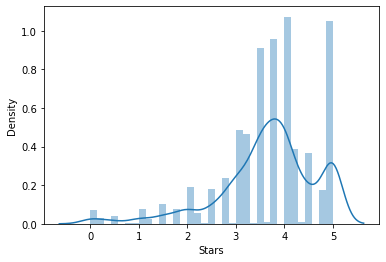

<IPython.core.display.Javascript object>

In [6]:
sns.distplot(df["Stars"])
plt.show()

In [7]:
# exploring possible groups to analyze

<IPython.core.display.Javascript object>

In [8]:
df["Brand"].value_counts()

Nissin             381
Nongshim            98
Maruchan            76
Mama                71
Paldo               66
                  ... 
Maitri               1
Kim's Bowl           1
Liang Cheng Mai      1
Kimura               1
ChoripDong           1
Name: Brand, Length: 355, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
df["Style"].value_counts()

Pack    1528
Bowl     481
Cup      450
Tray     108
Box        6
Bar        1
Can        1
Name: Style, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# Does pack or dish = (bowl, cup, tray) have a higher ratings

<IPython.core.display.Javascript object>

In [11]:
style_filter = df["Style"].isin(["Pack", "Bowl", "Cup", "Tray"])
df = df[style_filter]

<IPython.core.display.Javascript object>

c:\users\matth\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


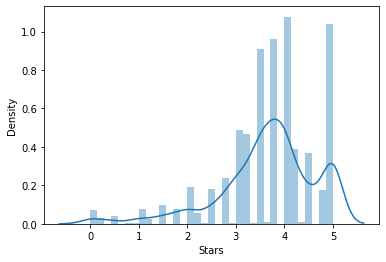

<IPython.core.display.Javascript object>

In [12]:
sns.distplot(df["Stars"])
plt.show()

<AxesSubplot:xlabel='Style', ylabel='Stars'>

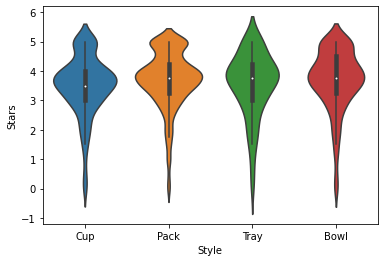

<IPython.core.display.Javascript object>

In [13]:
#slow code, uncomment for more visualizations
# sns.violinplot(x="Style", y="Stars", data=df)

<AxesSubplot:xlabel='Style', ylabel='Stars'>

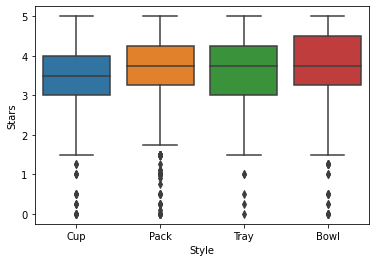

<IPython.core.display.Javascript object>

In [14]:
sns.boxplot(x="Style", y="Stars", data=df)

In [15]:
# slow code
# sns.swarmplot(x="Style", y="Stars", data=df)

<IPython.core.display.Javascript object>

In [16]:
df.groupby("Style").agg({"Stars": ["mean", "std", "size", "median"]})

Stars                       
           mean       std  size median
Style                                 
Bowl   3.670686  1.062804   481   3.75
Cup    3.498500  1.032921   450   3.50
Pack   3.700458  0.982831  1528   3.75
Tray   3.545139  1.098993   108   3.75

<IPython.core.display.Javascript object>

* Cosidering ANOVA (independent groups being assumed)
* Need to Check annova assumptions (is it normal?)

In [17]:
cup = df[df["Style"] == "Cup"]
pack = df[df["Style"] == "Pack"]
tray = df[df["Style"] == "Tray"]
bowl = df[df["Style"] == "Bowl"]

<IPython.core.display.Javascript object>

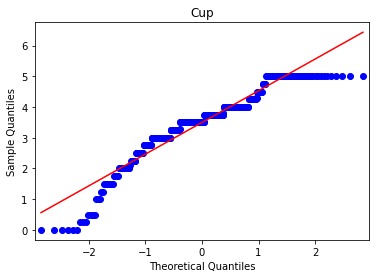

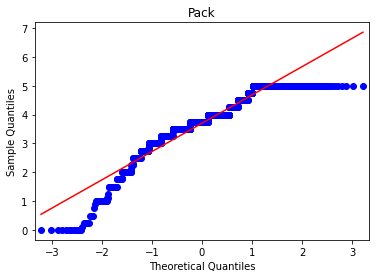

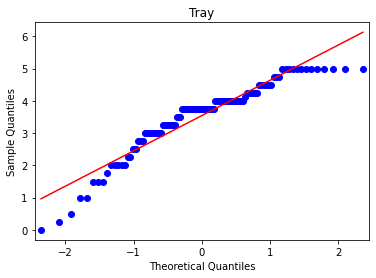

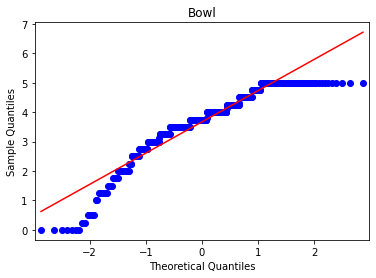

<IPython.core.display.Javascript object>

In [18]:
for style in [cup, pack, tray, bowl]:
    style_name = style["Style"].iloc[0]
    sm.qqplot(style["Stars"], line="s")
    plt.title(style_name)
    plt.show()

In [19]:
# these data sets are not normal.
# We will not move forward with ANOVA
# We will move forward with non-parametric test: Kruskal Wallis

<IPython.core.display.Javascript object>

In [20]:
h, p = stats.kruskal(cup["Stars"], pack["Stars"], tray["Stars"], bowl["Stars"])
p

0.0003115023977099646

<IPython.core.display.Javascript object>

* we see at least one group whos median is different. Now we will follow up with a kruskal wallis and be sure to correct alpha for multiple testing.

In [ ]:
# can consider looking into intertools combinations.
# n choose k
# 4 choose 2

In [23]:
_, p_cp = stats.kruskal(cup["Stars"], pack["Stars"])
_, p_ct = stats.kruskal(cup["Stars"], tray["Stars"])
_, p_cb = stats.kruskal(cup["Stars"], bowl["Stars"])
_, p_pt = stats.kruskal(pack["Stars"], tray["Stars"])
_, p_pb = stats.kruskal(pack["Stars"],  bowl["Stars"])
_, p_tb = stats.kruskal(tray["Stars"], bowl["Stars"])


<IPython.core.display.Javascript object>

In [25]:
p_vals = [p_cp, p_ct, p_cb, p_pt, p_pb, p_tb]
multipletests(p_vals)

(array([ True, False,  True, False, False, False]),
 array([1.67511035e-04, 7.12061060e-01, 4.18755913e-03, 7.12061060e-01,
        9.47419740e-01, 7.12061060e-01]),
 0.008512444610847103,
 0.008333333333333333)

<IPython.core.display.Javascript object>

* The test shows the following pairs are significantly different:
    * cup vs pack
    * cup vs bowl


In [31]:
# if we were to choose a random rating from each style
# we'd expect a pack rating to be higher 51.4% of the time
cles_ind(cup["Stars"], pack["Stars"])

0.514368819080861

<IPython.core.display.Javascript object>

In [52]:
# if we were to choose a random rating from each style
# we'd expect a pack rating to be higher 51.6% of the time
cles_ind(cup["Stars"], bowl["Stars"])

0.515902055902056

<IPython.core.display.Javascript object>

Bootstrapped CI of median diff

In [60]:
def bootstrap_median_diff(x1, x2, n=10000):
    median_diffs = []
    for i in range(n):
        s1 = x1.sample(frac=1.0, replace=True)
        s2 = x2.sample(frac=1.0, replace=True)

        median_diff = s1.median() - s2.median()
        median_diffs.append(median_diff)
        
    return median_diffs




<IPython.core.display.Javascript object>

In [61]:
diffs_cp = bootstrap_median_diff(cup["Stars"], pack["Stars"])
diffs_cb = bootstrap_median_diff(cup["Stars"], bowl["Stars"])

<IPython.core.display.Javascript object>

In [62]:
ci_lo_cp = np.percentile(diffs_cp, 2.5)
ci_hi_cp = np.percentile(diffs_cp, 97.5)
ci_lo_cb = np.percentile(diffs_cb, 2.5)
ci_hi_cb = np.percentile(diffs_cb, 97.5)

<IPython.core.display.Javascript object>

In [63]:
ci_lo_cp, ci_hi_cp

(-0.25, 0.0)

<IPython.core.display.Javascript object>

In [64]:
ci_lo_cb, ci_hi_cb

(-0.5, 0.0)

<IPython.core.display.Javascript object>

Pack score is about 0 to 0.25 stars higher than cups 

Bowl score is about 0 to 0.5 stars higher than cups 